In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import os
import sys
from datetime import datetime
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

### Loading Price Data

In [2]:
# Get the absolute path to the 'src' directory
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
src_path = os.path.join(project_root, "src")

# Add 'src' to system path
if src_path not in sys.path:
    sys.path.append(src_path)

from create_Dataframe import createDataframe as create_df
merged_data_summer = create_df('summer')
merged_data_winter = create_df('winter')

print(merged_data_summer.head())
merged_data_summer.head()

#Spotmarket data from: https://energy-charts.info/charts/price_spot_market/chart.htm?l=en&c=CH&interval=month&year=2024&legendItems=by4&month=12


/Users/simonbernet/Desktop/Optimization in Energy Systems/Optimization Project/optimization_project/src/create_Dataframe.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
/Users/simonbernet/Desktop/Optimization in Energy Systems/Optimization Project/optimization_project/src/create_Dataframe.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


            timestamp  Spotmarket_(EUR/kWh)  Inflexible_Demand_(kWh)  \
0 2023-08-01 00:00:00               0.07165                 0.003996   
1 2023-08-01 01:00:00               0.06910                 0.026629   
2 2023-08-01 02:00:00               0.06682                 0.049898   
3 2023-08-01 03:00:00               0.06406                 0.003990   
4 2023-08-01 04:00:00               0.06407                 0.014756   

   PV_energy_production_kWh  ev_at_home_binary  distance_driven  \
0                       0.0                  1              0.0   
1                       0.0                  1              0.0   
2                       0.0                  1              0.0   
3                       0.0                  1              0.0   
4                       0.0                  1              0.0   

   ev_home_availability  weekday  
0                   1.0        1  
1                   1.0        1  
2                   1.0        1  
3                   1.0 

/Users/simonbernet/Desktop/Optimization in Energy Systems/Optimization Project/optimization_project/src/create_Dataframe.py:150: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_summer["timestamp"] = pd.to_datetime(
/Users/simonbernet/Desktop/Optimization in Energy Systems/Optimization Project/optimization_project/src/create_Dataframe.py:161: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pv_winter["timestamp"] = pd.to_datetime(


,timestamp,Spotmarket_(EUR/kWh),Inflexible_Demand_(kWh),PV_energy_production_kWh,ev_at_home_binary,distance_driven,ev_home_availability,weekday
0,2023-08-01 00:00:00,0.07165,0.003996,0.0,1,0.0,1.0,1
1,2023-08-01 01:00:00,0.06910,0.026629,0.0,1,0.0,1.0,1
2,2023-08-01 02:00:00,0.06682,0.049898,0.0,1,0.0,1.0,1
3,2023-08-01 03:00:00,0.06406,0.003990,0.0,1,0.0,1.0,1
4,2023-08-01 04:00:00,0.06407,0.014756,0.0,1,0.0,1.0,1


### Dishwasher

In [4]:
# Load data
price = merged_data_summer["Spotmarket_(EUR/kWh)"].values
inflexibles = merged_data_summer["Inflexible_Demand_(kWh)"].values

Time_interval = len(price)  # Total time interval in hours

# Dishwasher properties
duration = 3  # hours of operation
min_gap = 15  # hours between runs
power_dishwasher = 1.5  # kW during operation

# Gurobi model
model = gp.Model("automated_demand_response")

# Binary start variables: 1 if dishwasher starts at hour t
start_times = range(Time_interval - duration + 1)
dishwasher_start = model.addVars(start_times, vtype=GRB.BINARY, name="start")

# Binary on variables: 1 if dishwasher is on at hour t
binary_dishwasher = model.addVars(Time_interval, vtype=GRB.BINARY, name="on")

for t, k in itertools.product(range(len(start_times)), range(duration)):
    model.addConstr(binary_dishwasher[t + k] >= dishwasher_start[t], name=f"dishwasher_{t}_{k}")

for t in range(len(start_times)-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t + k] for k in range(duration+1)) <= 3, name=f"max_three_hours_on_{t}")


# Enforce min 1 run per day
#adds up all possible start times of the dishwasher in a single and '>= 1' day ensures that the dishwasher has to run once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(dishwasher_start[t] for t in range(d * 24, (d + 1) * 24)) == 1,
                name=f"min_one_run_per_day_dishwasher_{d}")
    
# Enforce max 1 run per day of max 3 hours
#adds up all possible start times of the dishwasher in a single and '<= 1' day ensures that the dishwasher doesn't run more than once per day
hours_per_day = 24
days = Time_interval // hours_per_day
for d in range(days-1):
    model.addConstr(gp.quicksum(binary_dishwasher[t] for t in range(d * 24, (d + 1) * 24)) == 3,
                name=f"max_one_run_per_day_dishwasher_{d}")

# Enforce minimum gap (15 hours) between two starts
#multiplying with min_gap so we don't constrain the dishwasher to start at the same time every day
#this enures that the optimizer can iterate through without being constrained to a single time
for t in range(len(start_times)-min_gap):
    model.addConstr(gp.quicksum(dishwasher_start[t + offset] for offset in range(1, min_gap + 1)) <= (1 - dishwasher_start[t]) * min_gap,
                name=f"min_gap_after_{t}")
    
#print(len(fridge))
#print(len(stove))
#print(len(tv))
#print(len(lighting))
#print(len(price))
#print(len(dishwasher_start))
#print(len(binary_dishwasher))
#print(len(start_times))



Set parameter Username
Set parameter LicenseID to value 2653942
Academic license - for non-commercial use only - expires 2026-04-17


### Washing Machine

In [5]:
model.update()
### including the washing machine
# washing_machine properties
duration_wm = 2  # hours of operation
min_gap_wm = 1  # hours between runs
power_wm = 3  # kW during operation -> should be double checked
wm_runs_per_week = 4

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# Binary start variables: 1 if washing machine starts at hour t

start_times_wm = range(Time_interval - duration_wm + 1)
wm_start = model.addVars(start_times_wm, vtype=GRB.BINARY, name="start_wm")

# Binary on variables: 1 if washing machine is on at hour t

binary_wm = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_wm")

# When washing machine is on, it must be running -> wm_start is 1 -> binary_wm at the same time + duration_wm is 1 

for t, k in itertools.product(range(len(start_times_wm)), range(duration_wm)):
    model.addConstr(binary_wm[t + k] >= wm_start[t], name=f"wm_{t}_{k}")

for t in range(len(start_times_wm)-duration_wm):
    model.addConstr(gp.quicksum(binary_wm[t + k] for k in range(duration_wm+1)) <= duration_wm, name=f"wm_max_two_hours_on_{t}")


# Enforce min 4 runs per week -> if negative prices, can run more than 4 times, for now: exactly 4 times
#adds up all possible start times of the washing machine in a single week and '>= 1' day ensures that the washing machine has to run 4 times per week

hours_per_week = 24*7
weeks = Time_interval // hours_per_week
for week in range(weeks):
    model.addConstr(gp.quicksum(wm_start[t] for t in range(week * 24 * 7, (week + 1) * 24 * 7 -1)) == wm_runs_per_week,
                name=f"wm_four_runs_per_week_{week}")


# Enforce minimum gap (1 hour) between two starts

for t in range(len(start_times_wm)-min_gap_wm):
    model.addConstr(gp.quicksum(wm_start[t + offset] for offset in range(1, min_gap_wm + 1)) <= (1 - wm_start[t]) * min_gap_wm,
                name=f"min_gap_after_washing_wm_{t}")
    
#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_WM_summer'] = 0  # Initialize with 0
merged_data_winter['Allowed_WM_winter'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 1
    else: 
        merged_data_summer.loc[index, 'Allowed_WM_summer'] = 0


for index, row in merged_data_winter.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 20) or (day_of_week >= 5 and 8 <= hour < 20):
        merged_data_winter.loc[index, 'Allowed_WM_winter'] = 1
    else: 
        merged_data_winter.loc[index, 'Allowed_WM_winter'] = 0
        
model.addConstrs((binary_wm[t] <= merged_data_summer['Allowed_WM_summer'][t] for t in range(len(binary_wm))), name="allowed_wm_summer")
#model.addConstrs((binary_wm[t] <= merged_data_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter") #implement later




{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

### Dryer 

In [6]:
### including the dryer
# dryer properties
duration_dryer = 2  # hours of operation
max_gap_wm_dryer = 2  # hours between washing machine end and dryer start
power_dryer = 3  # kW during operation -> should be double checked


binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# Binary start variables: 1 if dryer starts at hour t

start_times_dryer = range(Time_interval - duration_dryer + 1)
dryer_start = model.addVars(start_times_dryer, vtype=GRB.BINARY, name="start_dryer")

# Binary on variables: 1 if dryer is on at hour t

binary_dryer = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_dryer")

# When dryer is on, it must be running -> dryer_start is 1 -> binary_dryer at the same time + duration_dryer is 1 

for t, k in itertools.product(range(len(start_times_dryer)), range(duration_dryer)):
    model.addConstr(binary_dryer[t + k] >= dryer_start[t], name=f"dryer_{t}_{k}")

for t in range(len(start_times_dryer)-duration_dryer):
    model.addConstr(gp.quicksum(binary_dryer[t + k] for k in range(duration_dryer+1)) <= duration_dryer, name=f"dryer_max_two_hours_on_{t}")


# Enforce minimum gap of 0 hours and max gap of 2 hours between two end of washing machine and start of dryer



# Enforce that the dryer starts within max_gap_wm_dryer hours after the washing machine ends
for t in range(len(dryer_start)-max_gap_wm_dryer-duration_wm):
    model.addConstr(gp.quicksum(dryer_start[t + offset + duration_wm] for offset in range(0, max_gap_wm_dryer + 1)) >= wm_start[t],
                name=f"max_gap_after_washing_dryer_{t}")



#washing machine can only run during certain hours of the day, during the week after 4pm and on weekends after 10am
# Add a new column to the dataframe indicating when the washing machine can be turned on
merged_data_summer['Allowed_dryer_summer'] = 0  # Initialize with 0
merged_data_winter['Allowed_dryer_winter'] = 0  # Initialize with 0

# Define the conditions for weekdays and weekends -> for summer and winter
for index, row in merged_data_summer.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 1
    else: 
        merged_data_summer.at[index, 'Allowed_dryer_summer'] = 0


for index, row in merged_data_winter.iterrows():
    hour = row['timestamp'].hour
    day_of_week = row['timestamp'].weekday()  # Monday=0, Sunday=6
    if (day_of_week < 5 and 16 <= hour < 22) or (day_of_week >= 5 and 8 <= hour < 22):
        merged_data_winter.at[index, 'Allowed_dryer_winter'] = 1
    else: 
        merged_data_winter.at[index, 'Allowed_dryer_winter'] = 0
        
model.addConstrs((binary_dryer[t] <= merged_data_summer['Allowed_dryer_summer'][t] for t in range(len(binary_dryer))), name="allowed_dryer_summer")
#model.addConstrs((binary_wm[t] <= merged_data_winter['Allowed_WM_winter'][t] for t in range(len(binary_wm))), name="allowed_wm_winter") #implement later

{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

### EV - G2V

In [7]:
# Include EV
#EV properties

min_power_ev = 1 #kW, minimum power to charge the EV
max_power_ev = 10 #kW, maximum power to charge the EV
kwh_per_km = 0.2  # kWh per km driven

max_capacity_ev = 70 #kWh

#Variables
#state of charge of the EV at each time step
soc_ev = model.addVars(Time_interval,lb=0, ub=max_capacity_ev, vtype=GRB.CONTINUOUS, name="soc_ev")
#how much power is being charged at each time step
charging_ev = model.addVars(Time_interval,lb=0, ub=max_power_ev, vtype=GRB.CONTINUOUS, name="charging_lvl_ev")
#binary variable to indicate if the EV is being charged at each time step
charging_binary_ev = model.addVars(Time_interval, vtype=GRB.BINARY, name="on_ev")


# Enforce SoC at 7:00 every day (hour 7 of each day)
for d in range(Time_interval // 24):
    t = d * 24 + 7  # 7:00 each day
    if t < Time_interval:
        model.addConstr(soc_ev[t] >= 0.8*max_capacity_ev, name=f"ev_soc_7am_day_{d}")

# car can only charge if it is at home
model.addConstrs((charging_binary_ev[t] <= merged_data_summer['ev_at_home_binary'][t] for t in range(len(charging_binary_ev))), name="allowed_ev_summer")

# if car is at home, it can charge, but not more than the maximum power
# and if it is charging, it must be charging at least the minimum power
model.addConstrs((charging_ev[t] <= max_power_ev * merged_data_summer['ev_home_availability'][t] * charging_binary_ev[t] for t in range(Time_interval)), name="max_power_ev")
model.addConstrs((charging_ev[t] >= min_power_ev * merged_data_summer['ev_home_availability'][t] * charging_binary_ev[t] for t in range(Time_interval)), name="min_power_ev")

# Constrain ev storage

initial_soc_ev = 20
model.addConstr(soc_ev[0] == initial_soc_ev, name="ev_soc_initial")



<gurobi.Constr *Awaiting Model Update*>

### PV and V2G

In [11]:
#for power produced with the PV system, the price is one half of the spot market price
merged_data_summer['feed_in_tariff'] = merged_data_summer['Spotmarket_(EUR/kWh)'] * 0.8
merged_data_winter['feed_in_tariff'] = merged_data_winter['Spotmarket_(EUR/kWh)'] * 0.8

ev_v2h_feed_in_binary = model.addVars(Time_interval, vtype=GRB.BINARY, name="ev_v2h_feed_in_binary")  # z[t] = 1 if EV is feeding in power
#add constraint, ev cant be charging and feeding in power at the same time
model.addConstrs((ev_v2h_feed_in_binary[t] + charging_binary_ev[t] <= 1 for t in range(Time_interval)), name="ev_v2h_feed_in_binary_constraint")
#add variable for ev if power is being fed into the grid
ev_feed_in_binary = model.addVars(Time_interval, vtype=GRB.BINARY, name="ev_feed_in_binary")  # z[t] = 1 if EV is feeding in power
#add constraint, ev cant be charging and feeding in power at the same time 
model.addConstrs((ev_feed_in_binary[t] + charging_binary_ev[t] <= 1 for t in range(Time_interval)), name="ev_feed_in_binary_constraint")
#add variable of power being fed into the grid by the EV
ev_feed_in_power = model.addVars(Time_interval, lb=0.0, name="ev_feed_in_power")  # Power fed into the grid by EV
ev_v2h_power = model.addVars(Time_interval, lb=0.0, name="ev_v2h_power")  # Power fed into the grid by EV in V2H mode

# if car is at home, it can feed-in, but not more than the maximum power
# and if it is feeding-in, it must be discharging at least the minimum power
model.addConstrs((ev_v2h_power[t] <= max_power_ev * merged_data_summer['ev_home_availability'][t] * ev_v2h_feed_in_binary[t] for t in range(Time_interval)), name="max_power_ev_v2h_feed_in")
model.addConstrs((ev_v2h_power[t] >= min_power_ev * merged_data_summer['ev_home_availability'][t] * ev_v2h_feed_in_binary[t] for t in range(Time_interval)), name="min_power_ev_v2h_feed_in")
model.addConstrs((ev_feed_in_power[t] <= max_power_ev * merged_data_summer['ev_home_availability'][t] * ev_feed_in_binary[t] for t in range(Time_interval)), name="max_power_ev_feed_in")
model.addConstrs((ev_feed_in_power[t] >= min_power_ev * merged_data_summer['ev_home_availability'][t] * ev_feed_in_binary[t] for t in range(Time_interval)), name="min_power_ev_feed_in")

#added up, the feed in is not allowed to be higher than the power introduced by the EV
model.addConstrs((ev_feed_in_power[t] + ev_v2h_power[t] <= max_power_ev * merged_data_summer['ev_home_availability'][t] for t in range(Time_interval)), name="ev_feed_in_power_limit")
#add constraint for state of charge of the EV
model.addConstrs((soc_ev[t] == soc_ev[t-1] + charging_ev[t-1] - ev_feed_in_power[t] - ev_v2h_power[t] - merged_data_summer['distance_driven'][t-1] * kwh_per_km for t in range(1,Time_interval)),name="ev_soc_update")

#add variable for total load minus the power produced by the PV system
#add gurobi variable that finds the min between load and pv production

# Total power consumption including fixed and dishwasher
total_load = {
    t: merged_data_summer['Inflexible_Demand_(kWh)'][t]+
       power_dishwasher * binary_dishwasher[t] +
       power_wm * binary_wm[t] + power_dryer * binary_dryer[t] + charging_ev[t]
    for t in range(Time_interval)
}


pv_maxed_binary = model.addVars(Time_interval, vtype=GRB.BINARY, name="pv_maxed")  # z[t] = 1 if load >= pv
M = 10000 #1.2 * merged_data_summer['PV_energy_production_kWh'].max() # Choose M large enough to cover max difference between pv and load
unmet   = model.addVars(Time_interval, lb=0.0, name="unmet_load")
pv_feed_in = model.addVars(Time_interval, lb=0.0, name="feed_in")

for t in range(Time_interval):
    pv = merged_data_summer['PV_energy_production_kWh'][t]
    load = total_load[t]
    
    # Binary switch: if PV > load → binary = 0; else 1
    model.addConstr(pv + ev_v2h_power[t] - load + unmet[t] - pv_feed_in[t] == 0, name=f"pv_load_balance_{t}")
    model.addConstr(pv_feed_in[t] <= (1-pv_maxed_binary[t]) * M , name=f"curtail_pv_{t}_2")
    model.addConstr(unmet[t] <= pv_maxed_binary[t] * M, name=f"unmet_load_{t}_2")



### Objective Function and Optimization

do we have a system where PV can be fed into the system and money is earned or not...
-> change the price if needed
as implemented now: V2G and PV feed into the grid at the same price. 

In [12]:
# Objective: minimize total electricity cost

model.setObjective(gp.quicksum(price[t] * unmet[t] - ev_feed_in_power[t] * merged_data_summer['feed_in_tariff'][t] - pv_feed_in[t] * merged_data_summer['feed_in_tariff'][t] for t in range(Time_interval)), GRB.MINIMIZE)
model.update()
# Optimize
model.optimize()

### careful, will have to sync the time because the last week is sometimes omitted and not necessarily a full week so maybe will have to optimize over 5 weeks instead

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 21.6.0 21H1320)

CPU model: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 20875 rows, 14780 columns and 59170 nonzeros
Model fingerprint: 0x9922d688
Variable types: 5376 continuous, 9404 integer (9404 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+04]
  Objective range  [2e-03, 2e-01]
  Bounds range     [1e+00, 7e+01]
  RHS range        [2e-03, 1e+04]
Presolve removed 12254 rows and 7673 columns
Presolve time: 0.34s
Presolved: 8621 rows, 7107 columns, 31617 nonzeros
Variable types: 3112 continuous, 3995 integer (3995 binary)
Found heuristic solution: objective 116.9429964

Root relaxation: objective 6.305369e+01, 3385 iterations, 0.06 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time



### Debugging

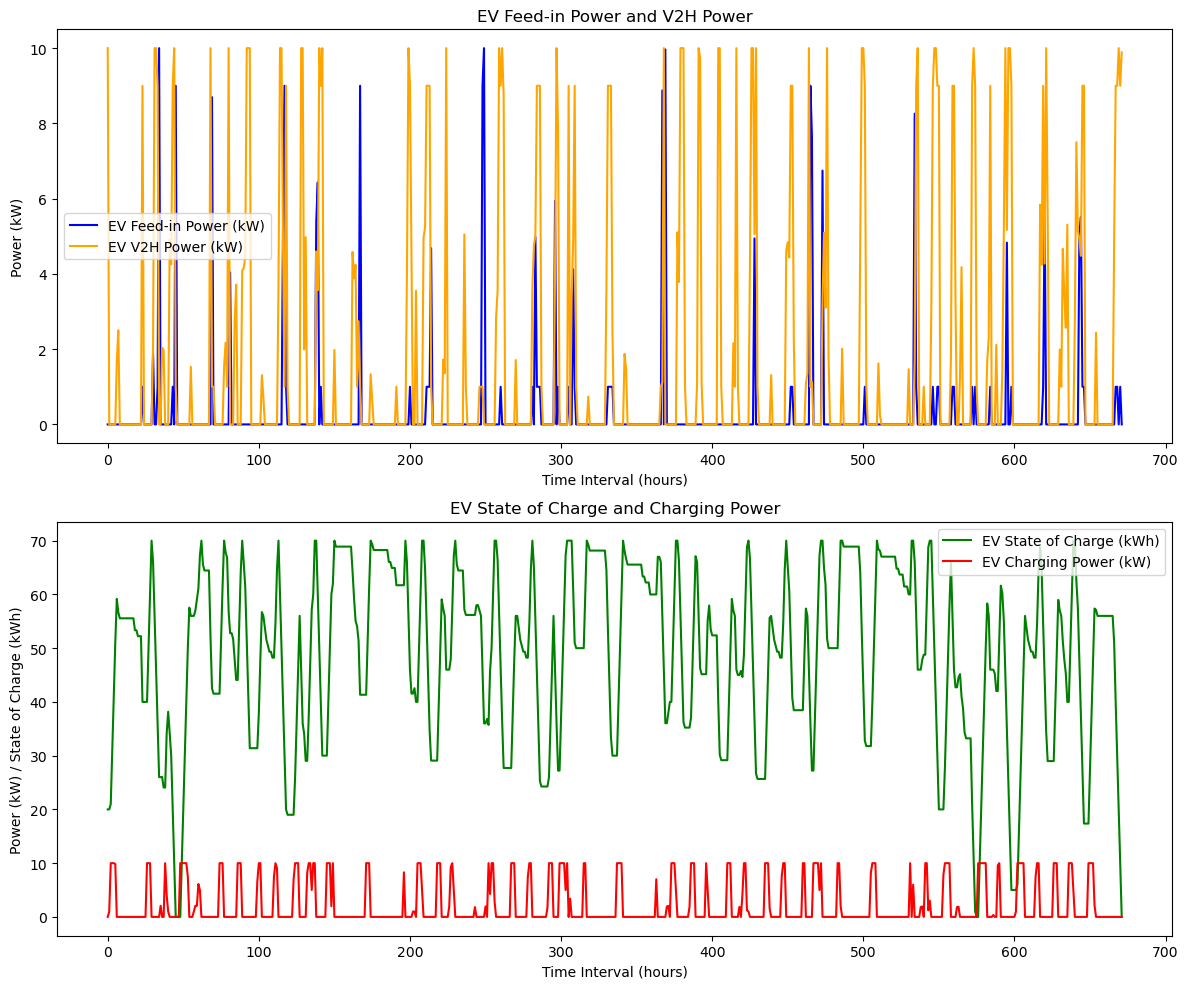

Optimal objective value: 66.02669006906316
Dishwasher start times:
Dishwasher starts at hour 0
Dishwasher starts at hour 26
Dishwasher starts at hour 48
Dishwasher starts at hour 75
Dishwasher starts at hour 109
Dishwasher starts at hour 133
Dishwasher starts at hour 157
Dishwasher starts at hour 182
Dishwasher starts at hour 205
Dishwasher starts at hour 229
Dishwasher starts at hour 251
Dishwasher starts at hour 277
Dishwasher starts at hour 300
Dishwasher starts at hour 323
Dishwasher starts at hour 349
Dishwasher starts at hour 373
Dishwasher starts at hour 397
Dishwasher starts at hour 419
Dishwasher starts at hour 445
Dishwasher starts at hour 468
Dishwasher starts at hour 490
Dishwasher starts at hour 514
Dishwasher starts at hour 530
Dishwasher starts at hour 565
Dishwasher starts at hour 590
Dishwasher starts at hour 612
Dishwasher starts at hour 637
Washing machine start times:
Washing machine starts at hour 108
Washing machine starts at hour 128
Washing machine starts at hou

In [13]:
#plot amount of power being fed into grid and into home by ev and another plot with state of charge and power consuption of ev
import matplotlib.pyplot as plt
# Extract results
ev_feed_in_power_values = [ev_feed_in_power[t].X for t in range(Time_interval)]
ev_v2h_power_values = [ev_v2h_power[t].X for t in range(Time_interval)]
soc_ev_values = [soc_ev[t].X for t in range(Time_interval)]
charging_ev_values = [charging_ev[t].X for t in range(Time_interval)]
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
# Plot EV feed-in power and V2H power
axs[0].plot(ev_feed_in_power_values, label='EV Feed-in Power (kW)', color='blue')   
axs[0].plot(ev_v2h_power_values, label='EV V2H Power (kW)', color='orange')
axs[0].set_title('EV Feed-in Power and V2H Power')
axs[0].set_xlabel('Time Interval (hours)')
axs[0].set_ylabel('Power (kW)')
axs[0].legend()
# Plot EV state of charge and charging power
axs[1].plot(soc_ev_values, label='EV State of Charge (kWh)', color='green')
axs[1].plot(charging_ev_values, label='EV Charging Power (kW)', color='red')
axs[1].set_title('EV State of Charge and Charging Power')
axs[1].set_xlabel('Time Interval (hours)')
axs[1].set_ylabel('Power (kW) / State of Charge (kWh)')
axs[1].legend() 
plt.tight_layout()
plt.show()

# Print the optimization results
if model.status == GRB.OPTIMAL:
    print("Optimal objective value:", model.objVal)
    print("Dishwasher start times:")
    for t in start_times:
        if dishwasher_start[t].X > 0.5:  # If the dishwasher starts at time t
            print(f"Dishwasher starts at hour {t}")
    print("Washing machine start times:")
    for t in start_times_wm:
        if wm_start[t].X > 0.5:  # If the washing machine starts at time t
            print(f"Washing machine starts at hour {t}")
    print("Dryer start times:")
    for t in start_times_dryer:
        if dryer_start[t].X > 0.5:  # If the dryer starts at time t
            print(f"Dryer starts at hour {t}")
    print("EV charging times:")
    for t in range(Time_interval):
        if charging_binary_ev[t].X > 0.5:  # If the EV is charging at time t
            print(f"EV is charging at hour {t} with power {charging_ev[t].X:.2f} kW")
    print("EV feed-in times:")
    for t in range(Time_interval):
        if ev_feed_in_binary[t].X > 0.5:  # If the EV is feeding in power at time t
            print(f"EV is feeding in power at hour {t} with power {ev_feed_in_power[t].X:.2f} kW")
    print("EV V2H feed-in times:")
    for t in range(Time_interval):
        if ev_v2h_feed_in_binary[t].X > 0.5:  # If the EV is feeding in power at time t
            print(f"EV V2H is feeding in power at hour {t} with power {ev_v2h_power[t].X:.2f} kW")
else:
    print("No optimal solution found. Status code:", model.status)


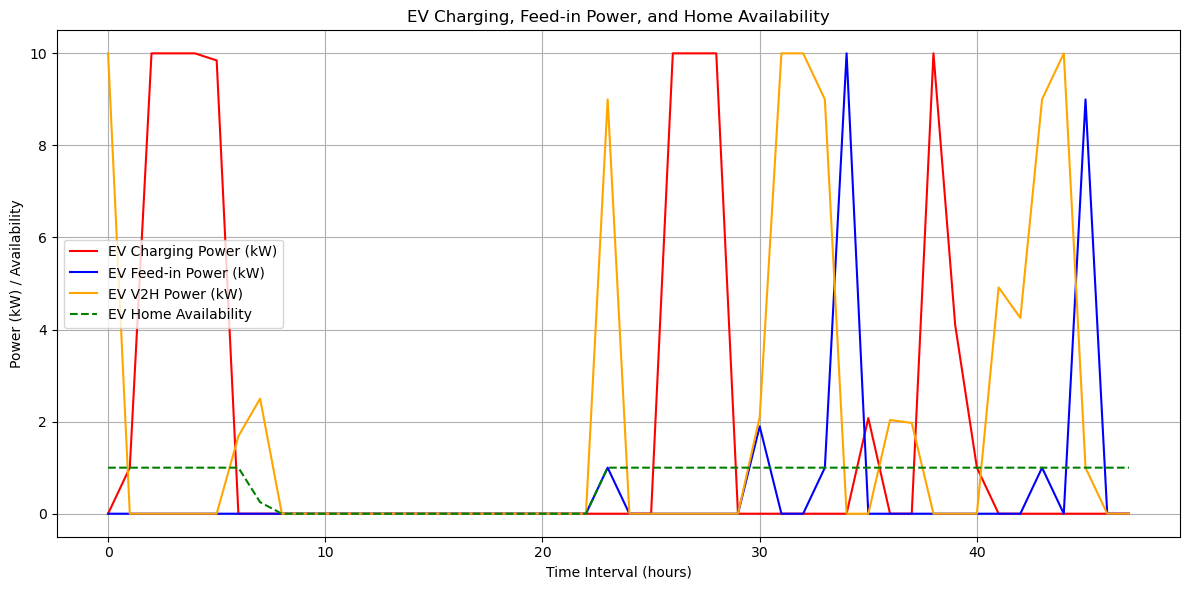

In [14]:
#plot 1 axis with ev charge, ev feed in v2h, ev feed in grid and one axis with availability of the ev at home
ev_home_availability = merged_data_summer['ev_home_availability'].values[:48]
# Create a new figure
plt.figure(figsize=(12, 6))
# Plot EV charging power
plt.plot(charging_ev_values[:48], label='EV Charging Power (kW)', color='red')
# Plot EV feed-in power
plt.plot(ev_feed_in_power_values[:48], label='EV Feed-in Power (kW)', color='blue')
# Plot EV V2H power
plt.plot(ev_v2h_power_values[:48], label='EV V2H Power (kW)', color='orange')
# Plot EV home availability
plt.plot(ev_home_availability[:48], label='EV Home Availability', color='green', linestyle='--')
# Add labels and title
plt.title('EV Charging, Feed-in Power, and Home Availability')
plt.xlabel('Time Interval (hours)')
plt.ylabel('Power (kW) / Availability')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
#plot 1 axis with ev charge, ev feed in v2h, ev feed in grid and one axis with availability of the ev at home





In [15]:
#debugging washing machine
wm_starts_list = []
# Output washing machine schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval-duration_wm+1):
        if wm_start[t].X > 0.5:
            print(f"Washing machine starts at: {merged_data_summer['timestamp'][t]}")
            wm_starts_list.append(merged_data_summer['timestamp'][t])


print("Washing machine schedule:")
print(wm_starts_list)

Total cost: 66.03
Washing machine starts at: 2023-08-05 12:00:00
Washing machine starts at: 2023-08-06 08:00:00
Washing machine starts at: 2023-08-06 11:00:00
Washing machine starts at: 2023-08-06 14:00:00
Washing machine starts at: 2023-08-12 13:00:00
Washing machine starts at: 2023-08-13 08:00:00
Washing machine starts at: 2023-08-13 11:00:00
Washing machine starts at: 2023-08-13 14:00:00
Washing machine starts at: 2023-08-19 10:00:00
Washing machine starts at: 2023-08-19 13:00:00
Washing machine starts at: 2023-08-20 10:00:00
Washing machine starts at: 2023-08-20 13:00:00
Washing machine starts at: 2023-08-26 11:00:00
Washing machine starts at: 2023-08-27 08:00:00
Washing machine starts at: 2023-08-27 11:00:00
Washing machine starts at: 2023-08-27 14:00:00
Washing machine schedule:
[Timestamp('2023-08-05 12:00:00'), Timestamp('2023-08-06 08:00:00'), Timestamp('2023-08-06 11:00:00'), Timestamp('2023-08-06 14:00:00'), Timestamp('2023-08-12 13:00:00'), Timestamp('2023-08-13 08:00:00'),

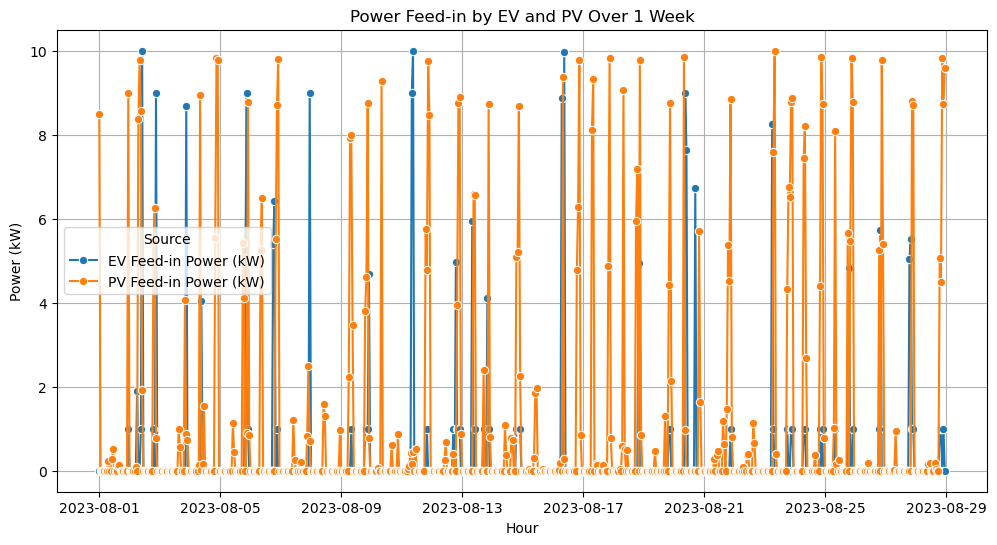

In [16]:
#plot amount of power fed into the grid by EV and PV 
import matplotlib.pyplot as plt
# Create a time range for the x-axis
time_range = pd.date_range(start=merged_data_summer['timestamp'].iloc[0], periods=Time_interval, freq='H')
# Create a DataFrame for plotting
data_feed_in = pd.DataFrame({
    'Hour': time_range,
    'EV Feed-in Power (kW)': [ev_feed_in_power[t].X for t in range(Time_interval)],
    'PV Feed-in Power (kW)': [pv_feed_in[t].X for t in range(Time_interval)]
})
# Melt for plotting
data_feed_in_melted = data_feed_in.melt(id_vars='Hour', var_name='Source', value_name='Power (kW)')
# Plot
plt.figure(figsize=(12, 6))
import seaborn as sns
sns.lineplot(data=data_feed_in_melted, x='Hour', y='Power (kW)', hue='Source', marker='o')
plt.title('Power Feed-in by EV and PV Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.legend(title='Source')
plt.grid(True)
plt.show()


In [17]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_wm[t].X > 0.5:
            print(f"Washing Machine is ON at: {merged_data_summer['timestamp'][t]}")
        else:
            print(f"Washing Machine is OFF at: {merged_data_summer['timestamp'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")

Washing Machine is OFF at: 2023-08-01 00:00:00
Washing Machine is OFF at: 2023-08-01 01:00:00
Washing Machine is OFF at: 2023-08-01 02:00:00
Washing Machine is OFF at: 2023-08-01 03:00:00
Washing Machine is OFF at: 2023-08-01 04:00:00
Washing Machine is OFF at: 2023-08-01 05:00:00
Washing Machine is OFF at: 2023-08-01 06:00:00
Washing Machine is OFF at: 2023-08-01 07:00:00
Washing Machine is OFF at: 2023-08-01 08:00:00
Washing Machine is OFF at: 2023-08-01 09:00:00
Washing Machine is OFF at: 2023-08-01 10:00:00
Washing Machine is OFF at: 2023-08-01 11:00:00
Washing Machine is OFF at: 2023-08-01 12:00:00
Washing Machine is OFF at: 2023-08-01 13:00:00
Washing Machine is OFF at: 2023-08-01 14:00:00
Washing Machine is OFF at: 2023-08-01 15:00:00
Washing Machine is OFF at: 2023-08-01 16:00:00
Washing Machine is OFF at: 2023-08-01 17:00:00
Washing Machine is OFF at: 2023-08-01 18:00:00
Washing Machine is OFF at: 2023-08-01 19:00:00
Washing Machine is OFF at: 2023-08-01 20:00:00
Washing Machi

In [18]:
#debugging dishwasher

dishwasher_starts_list = []
# Output dishwasher schedule
if model.status == GRB.OPTIMAL:
    print(f"Total cost: {model.ObjVal:.2f}")
    for t in range(Time_interval):
        if dishwasher_start.get(t) and dishwasher_start[t].X > 0.5:
            print(f"Dishwasher starts at: {merged_data_summer['timestamp'][t]}")
            dishwasher_starts_list.append(merged_data_summer['timestamp'][t])


print("Dishwasher schedule:")
print(dishwasher_starts_list)

Total cost: 66.03
Dishwasher starts at: 2023-08-01 00:00:00
Dishwasher starts at: 2023-08-02 02:00:00
Dishwasher starts at: 2023-08-03 00:00:00
Dishwasher starts at: 2023-08-04 03:00:00
Dishwasher starts at: 2023-08-05 13:00:00
Dishwasher starts at: 2023-08-06 13:00:00
Dishwasher starts at: 2023-08-07 13:00:00
Dishwasher starts at: 2023-08-08 14:00:00
Dishwasher starts at: 2023-08-09 13:00:00
Dishwasher starts at: 2023-08-10 13:00:00
Dishwasher starts at: 2023-08-11 11:00:00
Dishwasher starts at: 2023-08-12 13:00:00
Dishwasher starts at: 2023-08-13 12:00:00
Dishwasher starts at: 2023-08-14 11:00:00
Dishwasher starts at: 2023-08-15 13:00:00
Dishwasher starts at: 2023-08-16 13:00:00
Dishwasher starts at: 2023-08-17 13:00:00
Dishwasher starts at: 2023-08-18 11:00:00
Dishwasher starts at: 2023-08-19 13:00:00
Dishwasher starts at: 2023-08-20 12:00:00
Dishwasher starts at: 2023-08-21 10:00:00
Dishwasher starts at: 2023-08-22 10:00:00
Dishwasher starts at: 2023-08-23 02:00:00
Dishwasher start

In [19]:
#print timestamp and the corresponding state of the dishwasher
if model.status == GRB.OPTIMAL:
    for t in range(Time_interval):
        if binary_dishwasher[t].X > 0.5:
            print(f"Dishwasher is ON at: {merged_data_summer['timestamp'][t]}")
        else:
            print(f"Dishwasher is OFF at: {merged_data_summer['timestamp'][t]}")
else:
    print("Model has not been solved to optimality. Unable to retrieve variable values.")


Dishwasher is ON at: 2023-08-01 00:00:00
Dishwasher is ON at: 2023-08-01 01:00:00
Dishwasher is ON at: 2023-08-01 02:00:00
Dishwasher is OFF at: 2023-08-01 03:00:00
Dishwasher is OFF at: 2023-08-01 04:00:00
Dishwasher is OFF at: 2023-08-01 05:00:00
Dishwasher is OFF at: 2023-08-01 06:00:00
Dishwasher is OFF at: 2023-08-01 07:00:00
Dishwasher is OFF at: 2023-08-01 08:00:00
Dishwasher is OFF at: 2023-08-01 09:00:00
Dishwasher is OFF at: 2023-08-01 10:00:00
Dishwasher is OFF at: 2023-08-01 11:00:00
Dishwasher is OFF at: 2023-08-01 12:00:00
Dishwasher is OFF at: 2023-08-01 13:00:00
Dishwasher is OFF at: 2023-08-01 14:00:00
Dishwasher is OFF at: 2023-08-01 15:00:00
Dishwasher is OFF at: 2023-08-01 16:00:00
Dishwasher is OFF at: 2023-08-01 17:00:00
Dishwasher is OFF at: 2023-08-01 18:00:00
Dishwasher is OFF at: 2023-08-01 19:00:00
Dishwasher is OFF at: 2023-08-01 20:00:00
Dishwasher is OFF at: 2023-08-01 21:00:00
Dishwasher is OFF at: 2023-08-01 22:00:00
Dishwasher is OFF at: 2023-08-01 23:0

In [20]:
#print dishwasher start times
for t in range(Time_interval-2):
    if dishwasher_start[t].X > 0.5:
        print(f"Dishwasher start time: {merged_data_summer['timestamp'][t]}")

Dishwasher start time: 2023-08-01 00:00:00
Dishwasher start time: 2023-08-02 02:00:00
Dishwasher start time: 2023-08-03 00:00:00
Dishwasher start time: 2023-08-04 03:00:00
Dishwasher start time: 2023-08-05 13:00:00
Dishwasher start time: 2023-08-06 13:00:00
Dishwasher start time: 2023-08-07 13:00:00
Dishwasher start time: 2023-08-08 14:00:00
Dishwasher start time: 2023-08-09 13:00:00
Dishwasher start time: 2023-08-10 13:00:00
Dishwasher start time: 2023-08-11 11:00:00
Dishwasher start time: 2023-08-12 13:00:00
Dishwasher start time: 2023-08-13 12:00:00
Dishwasher start time: 2023-08-14 11:00:00
Dishwasher start time: 2023-08-15 13:00:00
Dishwasher start time: 2023-08-16 13:00:00
Dishwasher start time: 2023-08-17 13:00:00
Dishwasher start time: 2023-08-18 11:00:00
Dishwasher start time: 2023-08-19 13:00:00
Dishwasher start time: 2023-08-20 12:00:00
Dishwasher start time: 2023-08-21 10:00:00
Dishwasher start time: 2023-08-22 10:00:00
Dishwasher start time: 2023-08-23 02:00:00
Dishwasher 

In [21]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Define the time range for one week
time_range = range(0, 24 * 7)  # 7 days, 24 hours each

# Create a DataFrame for the first plot
data_power = pd.DataFrame({
    'Hour': list(time_range),
    'Fridge': fridge[:len(time_range)],
    'Stove': stove[:len(time_range)],
    'TV': tv[:len(time_range)],
    'Lighting': lighting[:len(time_range)],
    'Oven': oven[:len(time_range)],
    'Dishwasher': [power_dishwasher * binary_dishwasher[t].X for t in time_range],
    'Washing Machine': [power_wm * binary_wm[t].X for t in time_range]
})

# Melt the data for easier plotting
data_power_melted = data_power.melt(id_vars='Hour', var_name='Technology', value_name='Power (kWh)')

# Plot 1: Power demand of all technologies
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_power_melted, x='Hour', y='Power (kWh)', hue='Technology')
plt.title('Power Demand of All Technologies Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Power (kWh)')
plt.legend(title='Technology')
plt.grid(True)
plt.show()

# Create a DataFrame for the second plot
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Dishwasher State': [binary_dishwasher[t].X for t in time_range],
    'Washing Machine State': [binary_wm[t].X for t in time_range]
})

# Melt the data for easier plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot 2: Binary on/off states of washing machine and dishwasher
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dishwasher Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()


NameError: name 'fridge' is not defined

In [24]:
#lengths of the lists

print("length of pv_summer:", len(pv_summer))
print("length of merged_data_summer:", len(merged_data_summer))
print("length of merged_data_winter:", len(merged_data_winter))
print("length of p_summer:", len(p_summer))
print("length of p_winter:", len(p_winter))
print("length of fridge_summer:", len(fridge_summer))
print("length of fridge_winter:", len(fridge_winter))
print("length of oven_summer:", len(oven_summer))
print("length of oven_winter:", len(oven_winter))
print("length of induction_summer:", len(induction_summer))
print("length of induction_winter:", len(induction_winter))
print("length of tv_summer:", len(tv_summer))
print("length of tv_winter:", len(tv_winter))
print("length of lighting_summer:", len(lighting_summer))
print("length of lighting_winter:", len(lighting_winter))
print("length curtailed:", len(curtail))
print("length unmet:", len(unmet))
print("length of total_load:", len(total_load))
print("length of price:", len(price))
print("length of binary_dishwasher:", len(binary_dishwasher))




length of pv_summer: 672
length of merged_data_summer: 672
length of merged_data_winter: 672
length of p_summer: 672
length of p_winter: 672
length of fridge_summer: 672
length of fridge_winter: 672
length of oven_summer: 672
length of oven_winter: 672
length of induction_summer: 672
length of induction_winter: 672
length of tv_summer: 672
length of tv_winter: 672
length of lighting_summer: 672
length of lighting_winter: 672


NameError: name 'curtail' is not defined

In [25]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Prepare data for plotting
time_range = range(Time_interval)  # Full time range
# Limit the time range to the first two weeks (2 weeks * 7 days * 24 hours = 336 hours)
time_range = range(72)

data_plot = pd.DataFrame({
    'Hour': list(time_range),
    'Total Load (kWh)': [total_load[t].getValue() for t in time_range],
    'PV Produced (kWh)': pv_summer['PV_energy_production_kWh'].iloc[:72].values,
    'Curtailed (kWh)': [curtail[t].X for t in time_range],
    'Unmet (kWh)': [unmet[t].X for t in time_range]
})

# Melt the data for easier plotting
data_plot_melted = data_plot.melt(id_vars='Hour', var_name='Category', value_name='Energy (kWh)')

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(data=data_plot_melted, x='Hour', y='Energy (kWh)', hue='Category', marker='o')
plt.title('Energy Overview: Load, PV Production, Curtailed, and Unmet Energy')
plt.xlabel('Hour')
plt.ylabel('Energy (kWh)')
plt.legend(title='Category')
plt.grid(True)
plt.show()

NameError: name 'curtail' is not defined

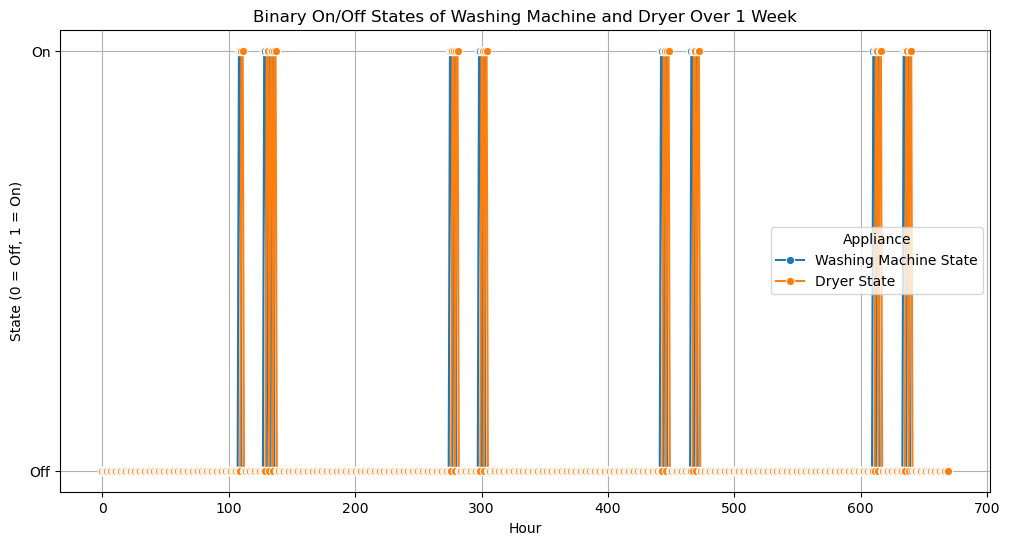

In [74]:
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Define the time range for one week (or adjust as needed)
time_range = range(0,670)  # 7 days, 24 hours each

# Prepare DataFrame for binary on/off states
data_binary = pd.DataFrame({
    'Hour': list(time_range),
    'Washing Machine State': [binary_wm[t].X for t in time_range],
    'Dryer State': [binary_dryer[t].X for t in time_range]
})

# Melt for plotting
data_binary_melted = data_binary.melt(id_vars='Hour', var_name='Appliance', value_name='State')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_binary_melted, x='Hour', y='State', hue='Appliance', marker='o')
plt.title('Binary On/Off States of Washing Machine and Dryer Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Appliance')
plt.grid(True)
plt.show()

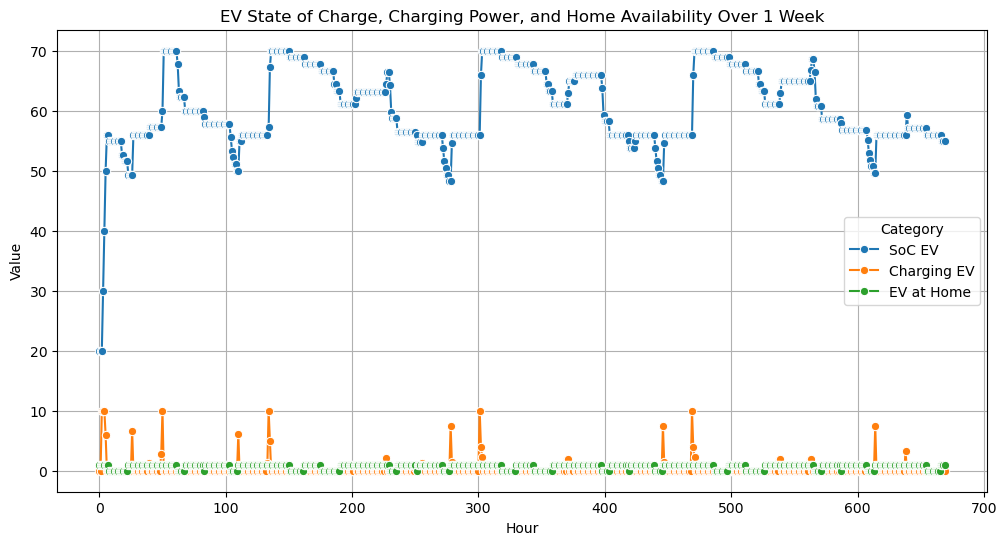

In [75]:
#plot the state of charge of the EV the driving and binary if at home or not 

data_ev = pd.DataFrame({
    'Hour': list(time_range),
    'SoC EV': [soc_ev[t].X for t in time_range],
    'Charging EV': [charging_ev[t].X for t in time_range],
    'EV at Home': [ev_summer['ev_at_home_binary'][t] for t in time_range]
})
# Melt for plotting
data_ev_melted = data_ev.melt(id_vars='Hour', var_name='Category', value_name='Value')
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_ev_melted, x='Hour', y='Value', hue='Category', marker='o')
plt.title('EV State of Charge, Charging Power, and Home Availability Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend(title='Category')
plt.grid(True)
plt.show()


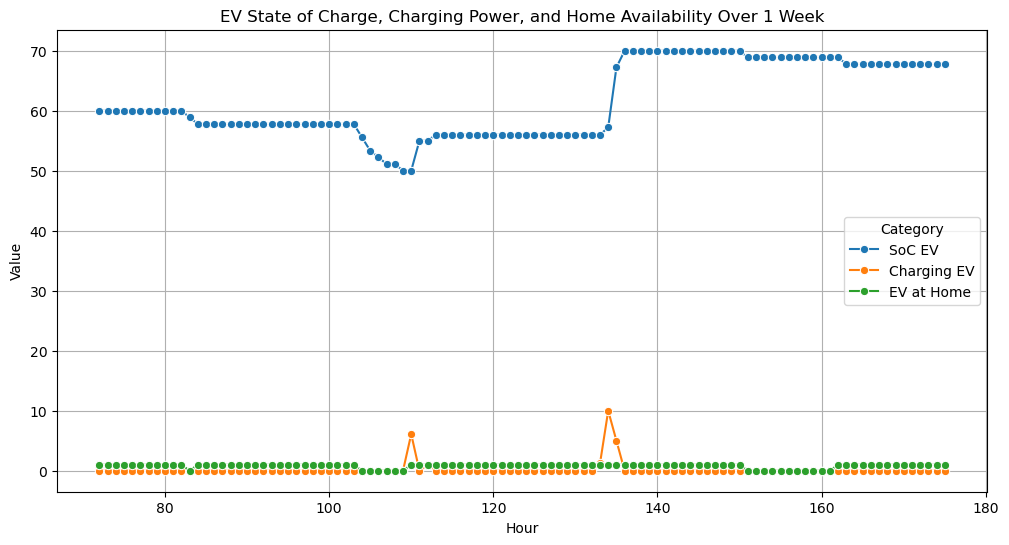

In [76]:
#same plot as before but just for one week
data_ev_one_week = pd.DataFrame({
    'Hour': list(range(72,176)),  # 7 days, 24 hours each
    'SoC EV': [soc_ev[t].X for t in range(72,176)],
    'Charging EV': [charging_ev[t].X for t in range(72,176)],
    'EV at Home': [ev_summer['ev_at_home_binary'][t] for t in range(72,176)]
})
# Melt for plotting
data_ev_one_week_melted = data_ev_one_week.melt(id_vars='Hour', var_name='Category', value_name='Value')    
# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=data_ev_one_week_melted, x='Hour', y='Value', hue='Category', marker='o')
plt.title('EV State of Charge, Charging Power, and Home Availability Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('Value')
plt.legend(title='Category')
plt.grid(True)
plt.show()

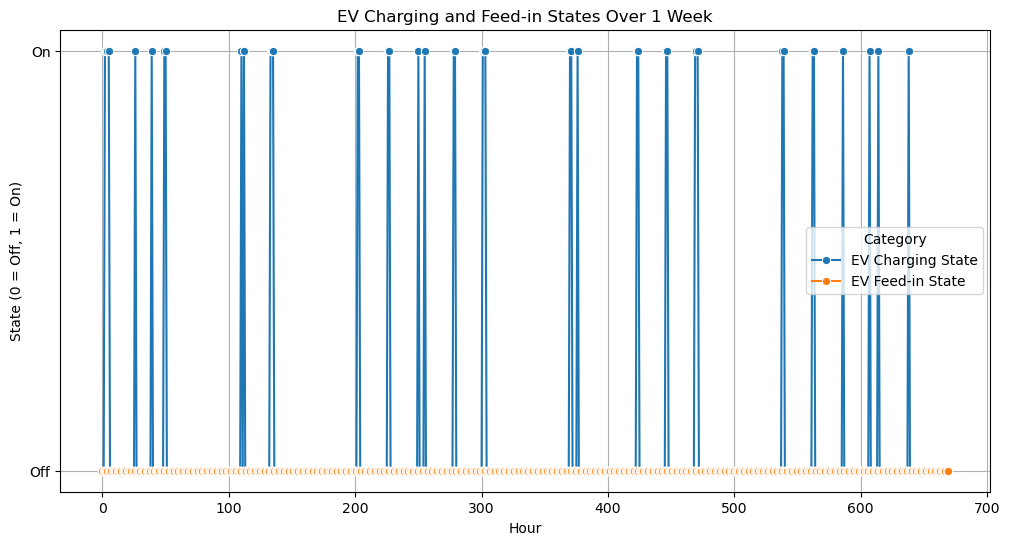

In [77]:
#plot the binary states of the EV
data_ev_binary = pd.DataFrame({
    'Hour': list(time_range),
    'EV Charging State': [binary_ev[t].X for t in time_range],
    'EV Feed-in State': [ev_feed_in_binary[t].X for t in time_range]
})
# Melt for plotting
data_ev_binary_melted = data_ev_binary.melt(id_vars='Hour', var_name='Category', value_name='State')
# Plot
plt.figure(figsize=(12, 6)) 
sns.lineplot(data=data_ev_binary_melted, x='Hour', y='State', hue='Category', marker='o')
plt.title('EV Charging and Feed-in States Over 1 Week')
plt.xlabel('Hour')
plt.ylabel('State (0 = Off, 1 = On)')
plt.yticks([0, 1], ['Off', 'On'])
plt.legend(title='Category')
plt.grid(True)
plt.show()